In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import os
import re
from src.bootstrap_error_analysis import *
from src.run_gsort_v2_wuericmod import get_vision_data,align_group_main,get_significant_electrodes

%load_ext autoreload
%autoreload 2
%matplotlib ipympl

/Volumes/Lab/Users/jeffbrown/g-sort/src/utilities/electrode_map.py:517: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  LITKE_512_ARRAY_ADJ_MAT = np.array([
/Volumes/Lab/Users/jeffbrown/g-sort/src/utilities/electrode_map.py:1552: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  LITKE_519_ARRAY_ADJ_MAT = np.array([


/Volumes/Lab/Users/jeffbrown/g-sort/src/utilities/visionloader.py


/Volumes/Lab/Users/jeffbrown/g-sort/src/electrode_map.py:517: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  LITKE_512_ARRAY_ADJ_MAT = np.array([
/Volumes/Lab/Users/jeffbrown/g-sort/src/electrode_map.py:1552: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  LITKE_519_ARRAY_ADJ_MAT = np.array([


In [15]:
dataset = "2020-09-29-2/"
estim = "data007/data007-all/"
vstim = "kilosort_data002/data002/"
file = f"/Volumes/Scratch/Users/jeffbrown/final_tests4/{dataset}{estim}{vstim}gsort_full_data_tensor.mat"
pickle_file = f"/Volumes/Scratch/Users/jeffbrown/final_tests4/{dataset}{estim}{vstim}gsort_full_data_tensor.mat"



In [16]:
loaded_data = loadmat(file)

In [17]:
loaded_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'cells', 'gsorted_cells', 'probs', 'filtered_probs', 'run'])

In [18]:
sorted_cells = loaded_data['gsorted_cells'].flatten()
cells = loaded_data['cells'].flatten()
run = loaded_data['run']
filtered_probs = loaded_data['filtered_probs']

In [53]:

cell = 124
cell_index = list(cells).index(cell)
p = 1
probs = filtered_probs[cell_index][p-1]

In [54]:
probs

array([0.  , 0.  , 0.05, ..., 0.  , 0.  , 0.  ])

In [47]:
run[cell_index]

array([1., 0.])

In [48]:
ANALYSIS_BASE = "/Volumes/Analysis/"

electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim)

triplet_elecs = mutils.get_stim_elecs_newlv(electrical_path, p)
amplitudes = mutils.get_stim_amps_newlv(electrical_path, p)

In [49]:
p_thr = 2/19
p_upper = 1

good_inds = np.where((probs > p_thr) & (probs < p_upper))[0]


/tmp/ipykernel_33766/4120017668.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


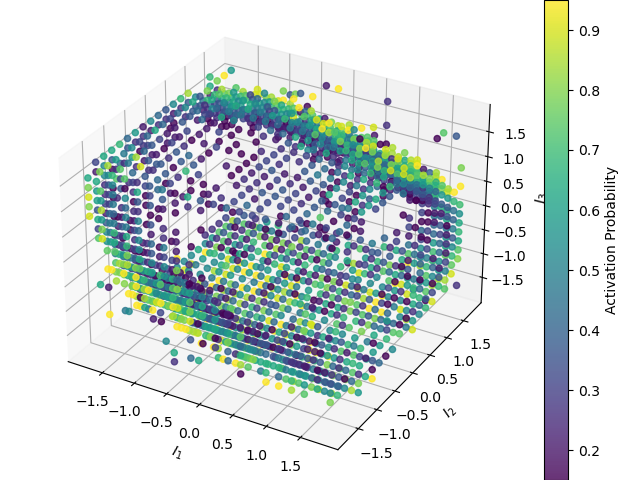

In [50]:
fig = plt.figure()
ax = Axes3D(fig)
plt.xlabel(r'$I_1$')
plt.ylabel(r'$I_2$')
ax.set_zlabel(r'$I_3$')
scat = ax.scatter(amplitudes[:, 0][good_inds], 
            amplitudes[:, 1][good_inds],
            amplitudes[:, 2][good_inds], marker='o', s=20, c=probs[good_inds], alpha=0.8)

ax.set_title(f"n={cell}, p={p}")
clb = plt.colorbar(scat)
clb.set_label('Activation Probability')
plt.show()

In [51]:
ax = plt.subplot(111)
ax.hist(probs)

(array([5664.,  493.,  348.,  306.,  280.,  156.,  240.,  217.,  158.,
         138.]),
 array([-2.22044605e-16,  9.50000000e-02,  1.90000000e-01,  2.85000000e-01,
         3.80000000e-01,  4.75000000e-01,  5.70000000e-01,  6.65000000e-01,
         7.60000000e-01,  8.55000000e-01,  9.50000000e-01]),
 <BarContainer object of 10 artists>)

In [60]:
ANALYSIS_BASE = "/Volumes/Analysis/"
gsort_path = "/Volumes/Scratch/Users/jeffbrown/final_tests4/"
dataset = "2020-09-29-2/"
estim = "data007/data007-all"
vstim = "kilosort_data002/data002"
thr_factor = 1
n = 124
ps = [int(re.findall('\d+', m)[-1]) for m in os.listdir(os.path.join(gsort_path, dataset, estim,vstim)) if (len(re.findall('\d+', m))==2) and (f"_n{n}_" in m)]

vcd = get_vision_data(ANALYSIS_BASE, dataset, vstim)
noise = vcd.channel_noise



pattern_movies, total_probs, edge_probs, clusters, edges, electrodes,num_trials = get_bootstrap_information(ANALYSIS_BASE, gsort_path,dataset, estim, vstim, ps,n, electrodes_stored = True)
# electrodes = get_significant_electrodes(ei, ['mixed','soma'], noise)
dss, dss_stack, dss_inds, num_electrodes, num_samples, movie_stack= get_difference_signals(pattern_movies,clusters,edges,ANALYSIS_BASE, dataset, estim, electrodes)
best_electrode = np.argmax(np.sum(vcd.get_ei_for_cell(n).ei[electrodes, :55]**2, axis = 1))

average_ds, average_error,std_error, shifted_dss, shifted_dss_stack,error, error_stack = compute_average_diff_signal_and_error(dss,dss_stack, num_electrodes, num_samples, best_electrode)



1it [00:00,  1.90it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 8000/8000 [04:37<00:00, 28.86it/s]


(50465, 21)
(50465, 21)


In [73]:
test_set = [i for i in range(len(electrodes))]
electrode = 0
factor =0
exp_error = np.array([np.sqrt(num_samples*2*(1.4*noise[e])**2) for e in electrodes])
# exp_error = np.array([4*noise[e] for e in electrodes])
# exp_error = np.array([np.sqrt(num_samples*2*noise[e]**2) for e in electrodes])


new_instance_probs = get_instance_modified_edge_probs(edge_probs, error, dss_inds, exp_error, std_error, factor, test_set,num_trials)
good_inds = np.where((new_instance_probs > p_thr) & (new_instance_probs < p_upper))[0]


/tmp/ipykernel_33766/957919646.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


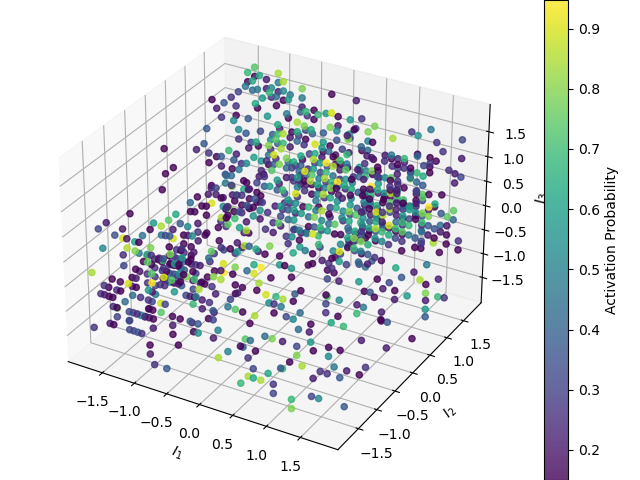

In [74]:
fig = plt.figure()
ax = Axes3D(fig)
plt.xlabel(r'$I_1$')
plt.ylabel(r'$I_2$')
ax.set_zlabel(r'$I_3$')
scat = ax.scatter(amplitudes[:, 0][good_inds], 
            amplitudes[:, 1][good_inds],
            amplitudes[:, 2][good_inds], marker='o', s=20, c=new_instance_probs[good_inds], alpha=0.8)

ax.set_title(f"n={cell}, p={p}")
clb = plt.colorbar(scat)
clb.set_label('Activation Probability')
plt.show()

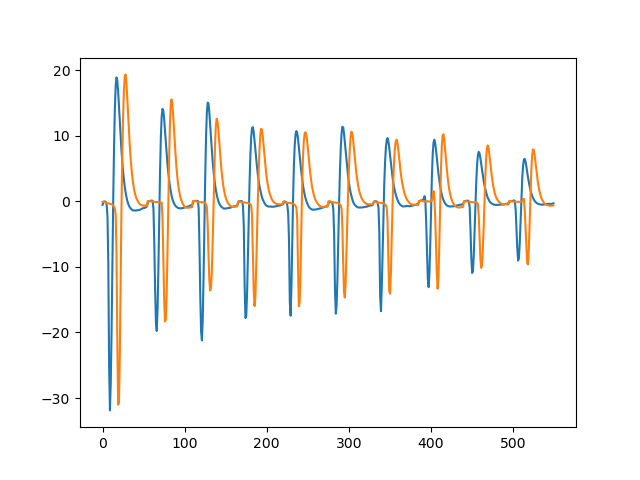

In [377]:
plt.figure()
ax = plt.subplot(111)
ax.plot(average_ds.flatten())
ax.plot(vcd.get_ei_for_cell(n).ei[electrodes, :55].flatten())

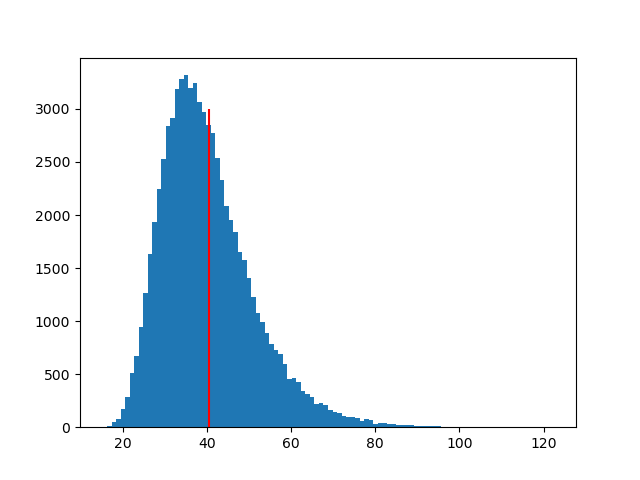

In [177]:
plt.figure()

plt.hist(error_stack[:,0], bins = 100);

# plt.vlines(average_error[0], 0, 80000, color = "black")

# plt.vlines(average_error[0], 0, 80000, color = "black")
exp_error = [np.sqrt(num_samples*2*noise[e]**2) for e in electrodes][0]

plt.vlines(exp_error, 0, 3000, color = "red")

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)
plt.xlabel(r'$I_1$')
plt.ylabel(r'$I_2$')
ax.set_zlabel(r'$I_3$')
scat = ax.scatter(amplitudes[:, 0][good_inds], 
            amplitudes[:, 1][good_inds],
            amplitudes[:, 2][good_inds], marker='o', s=20, c=probs[good_inds], alpha=0.8)

ax.set_title(f"n={cell}, p={p}")
clb = plt.colorbar(scat)
clb.set_label('Activation Probability')
plt.show()

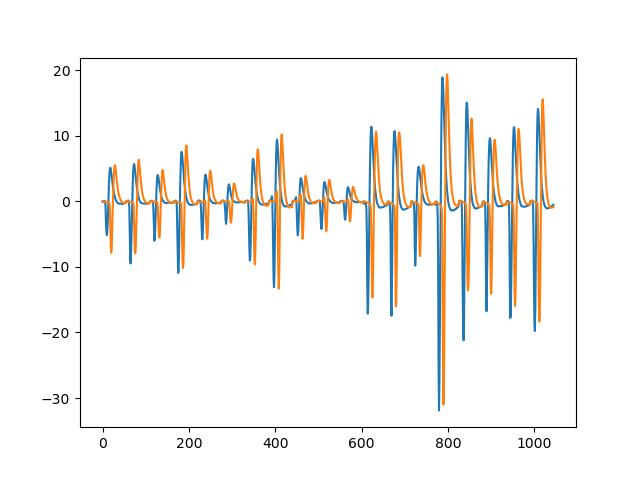

In [178]:
plt.figure()
ax = plt.subplot(111)
ax.plot(average_ds.flatten())
ax.plot(vcd.get_ei_for_cell(n).ei[electrodes, :55].flatten())

In [55]:

swept_indices, swept_amps= sweep_I3(  1.59375, 1.59375, amplitudes)

In [57]:
probs[swept_indices][np.argsort(swept_amps)]

array([ 7.36842105e-01,  0.00000000e+00,  2.63157895e-01,  0.00000000e+00,
        1.00000000e-01,  1.05263158e-01,  5.26315789e-02,  0.00000000e+00,
        4.21052632e-01,  4.00000000e-01,  1.00000000e-01,  5.26315789e-02,
        5.26315789e-02,  0.00000000e+00,  1.05263158e-01, -5.55111512e-17,
        2.63157895e-01,  2.10526316e-01,  0.00000000e+00,  0.00000000e+00])

In [58]:
np.sort(swept_amps)

array([-1.78125, -1.59375, -1.40625, -1.21875, -1.03125, -0.84375,
       -0.65625, -0.46875, -0.28125, -0.09375,  0.09375,  0.28125,
        0.46875,  0.65625,  0.84375,  1.03125,  1.21875,  1.40625,
        1.59375,  1.78125])

In [59]:
np.array(swept_indices)[np.argsort(swept_amps)]

array([3978, 3578, 3178, 2778, 2378, 1978, 1578, 1178,  778,  378, 4378,
       4778, 5178, 5578, 5978, 6378, 6778, 7178, 7578, 7978])

In [378]:
average_ds = [[np.array([align_group_main(sig_[:,i,:], sample_len = num_samples)[0] for i in range(num_electrodes)]) for sig_ in _sig] for _sig in dss]

In [379]:
average_ds_stack = np.stack([d for dd in average_ds for d in dd])

In [380]:
ei = vcd.get_ei_for_cell(n).ei
cell_eis = np.pad(ei[electrodes, :] , ((0,0),(55, 75)), mode='constant')


In [381]:
correlation = corr1d.batch_filter_batch_data_channel_correlate1D(
        cell_eis[None,:,:], average_ds_stack
    )
correlation_index = np.squeeze(np.argmax(correlation, axis = -1))


In [382]:
shifted_template = np.zeros_like(average_ds_stack)
for i, e in enumerate(electrodes):
    shifted_template[:,i,:] =np.array([[cell_eis[i,t] for t in range(l, l +num_samples)] for j, l in enumerate(correlation_index[:,i])])

array([[[-4.04169098, -2.27517713,  3.28489002, ..., -2.67007532,
         -0.6676183 , -0.22758392],
        [-1.79831609, -2.31121927, -1.61842107, ...,  1.79584644,
         -0.12508897,  0.44226629],
        [-2.8034745 , -5.76078343, -5.81040007, ..., -4.95960684,
         -4.29162665, -1.10222703],
        ...,
        [-1.67460072, -3.32130099, -3.54795128, ..., -0.69016617,
          0.31488414, -1.10425283],
        [-2.80255595, -4.05996807, -4.84982573, ..., -0.54225376,
         -0.44929656, -0.6519778 ],
        [-1.61865121, -3.42445286, -1.37629472, ..., -2.02777299,
         -3.6416435 , -3.35477721]],

       [[ 2.67201028,  2.4083432 ,  4.91124147, ...,  1.97353932,
          1.18935836,  2.65686199],
        [ 0.98343194, -0.55352232, -3.98313442, ...,  1.94749086,
          2.00609593,  1.3343454 ],
        [-1.48071875,  0.78952467,  2.79462923, ...,  0.64948882,
          3.36900553,  4.15970108],
        ...,
        [-4.30434239,  0.01141685, -5.34359212, ...,  

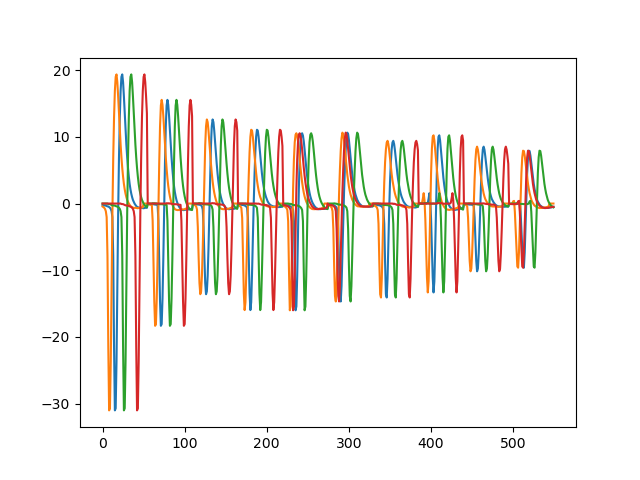

In [383]:
%notebook inline
plt.figure()
ax = plt.subplot(111)
ax.plot(shifted_template.reshape((shifted_template.shape[0],-1))[:4,:].T);

In [384]:
latencies = np.argmin(shifted_template[:,best_electrode,:], axis = 1)
all_latencies = np.argmin(shifted_template, axis = 2)

In [385]:
med_latency = np.median(latencies)
med_all_latencies = np.median(all_latencies, axis = 0, keepdims = True)

In [387]:
latency_shifted_template = np.zeros_like(average_ds_stack)
for i, e in enumerate(electrodes):
    latency_shifted_template[:,i,:] =np.array([[cell_eis[i,t] for t in range(l, l +num_samples)] for j, l in enumerate((correlation_index[:,i]+(latencies-med_latency)).astype(int))])

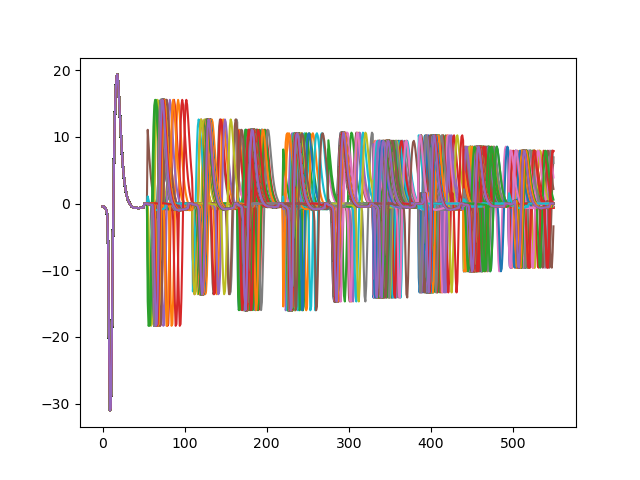

In [388]:
%notebook inline
plt.figure()
ax = plt.subplot(111)
ax.plot(latency_shifted_template.reshape((latency_shifted_template.shape[0],-1))[:505,:].T);
ax.set_xlim()

(array([ 103.,   12.,   72., 2627., 1474.,  359.,  183.,  101.,   97.,
          62.,   37.,   35.,   54.,   29.,   44.,   39.,   50.,   51.,
          36.,   54.,   50.,   45.,   29.,   37.,   44.]),
 array([ 0.  ,  2.12,  4.24,  6.36,  8.48, 10.6 , 12.72, 14.84, 16.96,
        19.08, 21.2 , 23.32, 25.44, 27.56, 29.68, 31.8 , 33.92, 36.04,
        38.16, 40.28, 42.4 , 44.52, 46.64, 48.76, 50.88, 53.  ]),
 <BarContainer object of 25 artists>)

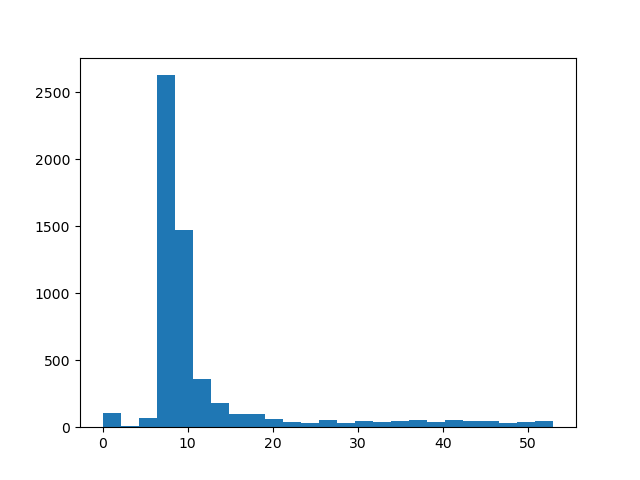

In [389]:
plt.figure()
ax = plt.subplot(111)
ax.hist(latencies, bins = 25)

In [390]:
shifted_template_reshape = latency_shifted_template.reshape((latency_shifted_template.shape[0],-1))

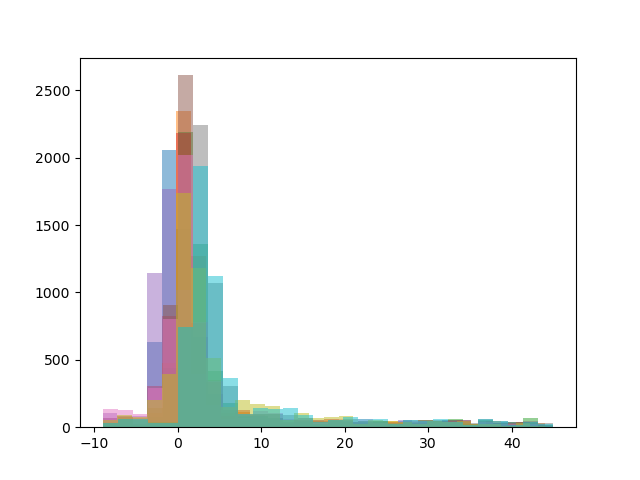

In [427]:
plt.figure()
ax = plt.subplot(111)
# ax.hist(latencies, bins = 25)
for e in range(len(electrodes)):
    ax.hist(all_latencies[:,e]-med_latency, bins = 30, alpha = 0.5)

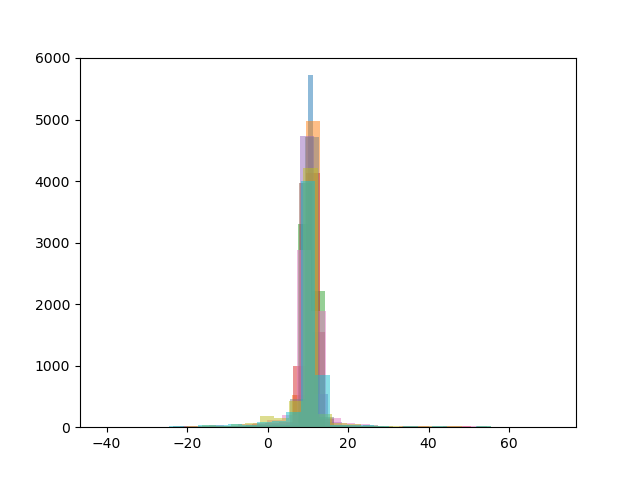

In [437]:
plt.figure()
ax = plt.subplot(111)
# ax.hist(latencies, bins = 25)
for e in range(len(electrodes)):
    ax.hist((correlation_index+(latencies-med_latency)[:, None]-55)[:,e], bins = 30, alpha = 0.5)
# ax.vlines(3.5, 0, 3000, color = 'black')
# ax.vlines(-3.5, 0, 3000, color = 'black')

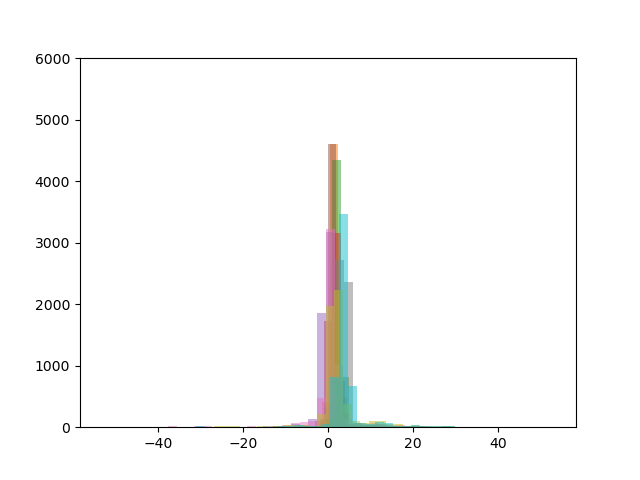

In [447]:
plt.figure()
ax = plt.subplot(111)

for e in range(len(electrodes)):
    ax.hist((all_latencies-latencies[:,None])[:,e], bins = 50, alpha = 0.5)


In [400]:
in_range_ds = np.all( ((all_latencies-med_all_latencies) <= 3.5) * ((all_latencies-med_all_latencies) >= -3.5), axis = 1)

In [425]:
len([pp for p in edge_probs for pp in list(p) if p[0] > 0.0])

5724

In [421]:
len(all_latencies)

5724

In [448]:
aligned_latencies = all_latencies-latencies[:,None]

In [453]:
median_aligned_latencies = np.median(aligned_latencies, axis = 0, keepdims = True)

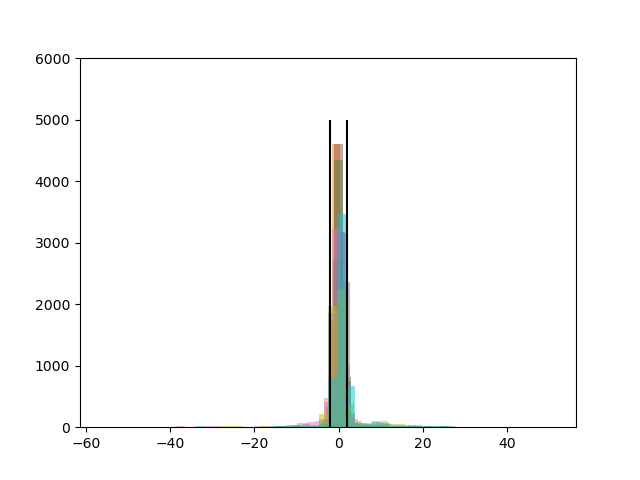

In [466]:
plt.figure()
ax = plt.subplot(111)

for e in range(len(electrodes)):
    ax.hist((aligned_latencies-median_aligned_latencies)[:,e], bins = 50, alpha = 0.5)
ax.vlines(2, 0, 5000, color = 'black')
ax.vlines(-2, 0, 5000, color = 'black')

In [461]:
x = aligned_latencies-median_aligned_latencies

In [457]:
from scipy import stats

In [462]:
stats.median_abs_deviation(x, axis = 0)

array([0., 1., 1., 1., 1., 0., 1., 1., 1., 1.])

In [487]:
in_range_ds = np.all(np.abs(aligned_latencies-median_aligned_latencies)<=2, axis = 1)

In [492]:
np.mean(in_range_ds)

0.5127533193570929

In [489]:
count = 0
aligned_probs = np.zeros(len(edge_probs))
for i, e_ps in enumerate(edge_probs):
    if e_ps[0] == -1:
        continue
    for e_p in e_ps:
        if in_range_ds[count]:
            aligned_probs[i] += e_p
        count += 1
        

In [490]:
aligned_probs

array([0.  , 0.  , 0.05, ..., 0.  , 0.  , 0.  ])

/tmp/ipykernel_24043/2787438454.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


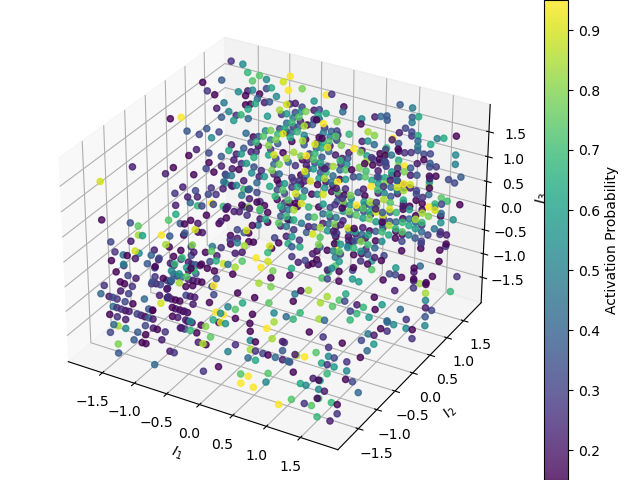

In [491]:
fig = plt.figure()
ax = Axes3D(fig)
plt.xlabel(r'$I_1$')
plt.ylabel(r'$I_2$')
ax.set_zlabel(r'$I_3$')

good_inds = np.where((aligned_probs > p_thr) & (aligned_probs < p_upper))[0]

scat = ax.scatter(amplitudes[:, 0][good_inds], 
            amplitudes[:, 1][good_inds],
            amplitudes[:, 2][good_inds], marker='o', s=20, c=aligned_probs[good_inds], alpha=0.8)

ax.set_title(f"n={cell}, p={p}")
clb = plt.colorbar(scat)
clb.set_label('Activation Probability')
plt.show()

In [503]:
waveform_error = shifted_template-average_ds_stack

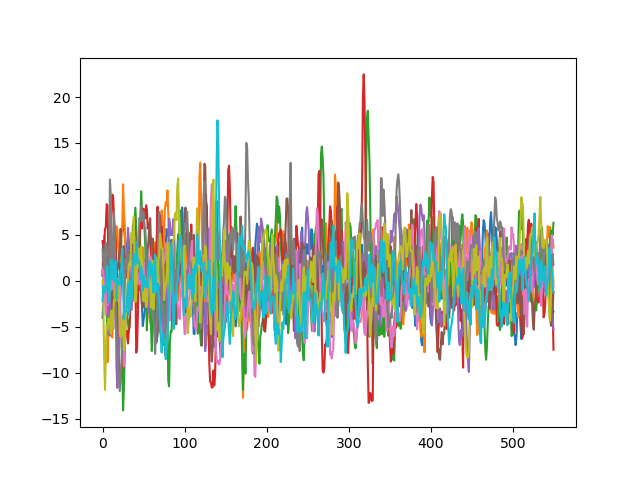

In [507]:
plt.figure()
ax = plt.subplot(111)
ax.plot(waveform_error.reshape((waveform_error.shape[0], -1))[:10,:].T);

In [515]:
error_distribution = np.linalg.norm(waveform_error.reshape((waveform_error.shape[0], -1)), axis = 1)

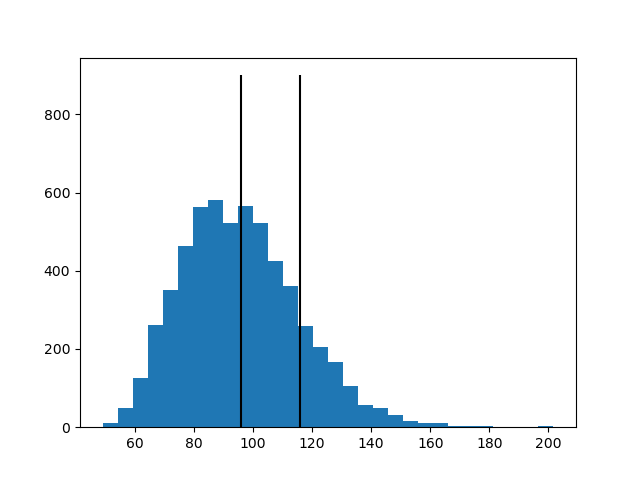

In [518]:
plt.figure()
ax = plt.subplot(111)
ax.hist(error_distribution, bins = 30);
ax.vlines(np.mean(error_distribution), 0, 900, color = 'black')
ax.vlines(np.mean(error_distribution)+1*np.std(error_distribution), 0, 900, color = 'black')

In [526]:
in_range_ds = error_distribution<=np.mean(error_distribution)#+1*np.std(error_distribution)

In [527]:
count = 0
aligned_probs = np.zeros(len(edge_probs))
for i, e_ps in enumerate(edge_probs):
    if e_ps[0] == -1:
        continue
    for e_p in e_ps:
        if in_range_ds[count]:
            aligned_probs[i] += e_p
        count += 1
        

/tmp/ipykernel_24043/2787438454.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


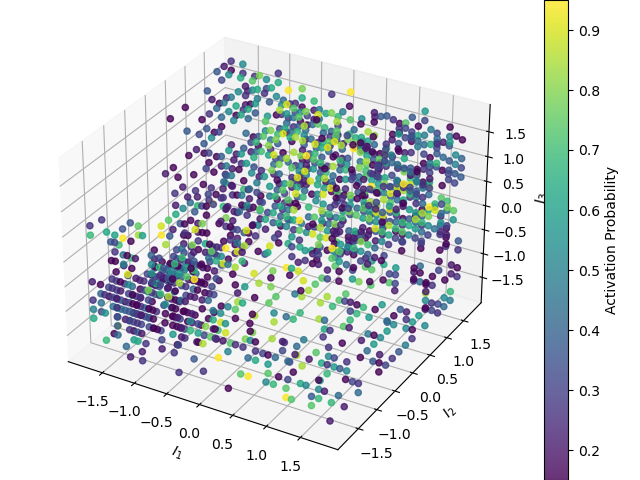

In [528]:
fig = plt.figure()
ax = Axes3D(fig)
plt.xlabel(r'$I_1$')
plt.ylabel(r'$I_2$')
ax.set_zlabel(r'$I_3$')

good_inds = np.where((aligned_probs > p_thr) & (aligned_probs < p_upper))[0]

scat = ax.scatter(amplitudes[:, 0][good_inds], 
            amplitudes[:, 1][good_inds],
            amplitudes[:, 2][good_inds], marker='o', s=20, c=aligned_probs[good_inds], alpha=0.8)

ax.set_title(f"n={cell}, p={p}")
clb = plt.colorbar(scat)
clb.set_label('Activation Probability')
plt.show()

(array([1465., 1039., 1828.,  781.,  701., 1165.,  451.,  443.,   87.,
          40.]),
 array([ 1. ,  2.4,  3.8,  5.2,  6.6,  8. ,  9.4, 10.8, 12.2, 13.6, 15. ]),
 <BarContainer object of 10 artists>)

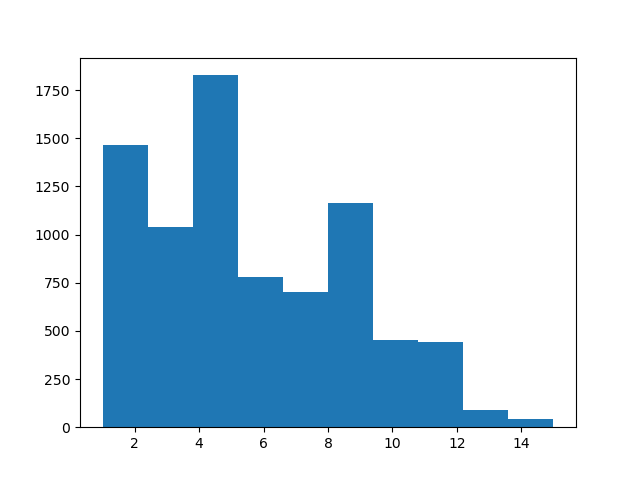

In [537]:
plt.figure()
ax = plt.subplot(111)
ax.hist()

In [549]:
num_trials

[20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,


/tmp/ipykernel_24043/4222283493.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


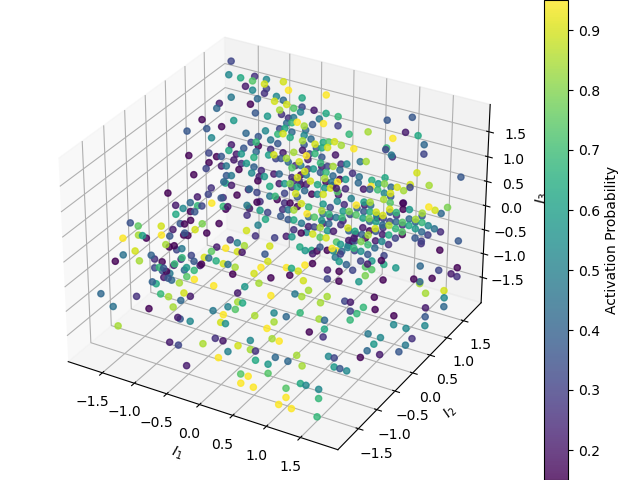

In [553]:
fig = plt.figure()
ax = Axes3D(fig)
plt.xlabel(r'$I_1$')
plt.ylabel(r'$I_2$')
ax.set_zlabel(r'$I_3$')
num_clusters = np.array([len(set(c)) for c in clusters])/num_trials
good_inds = (probs > p_thr) *(probs < p_upper)
thr = 6/num_trials[0]
scat = ax.scatter(amplitudes[:, 0][ good_inds * (num_clusters <thr)+(probs>0.8)], 
            amplitudes[:, 1][good_inds * (num_clusters <thr)+(probs>0.8)],
            amplitudes[:, 2][good_inds * (num_clusters <thr)+(probs>0.8)], marker='o', s=20, c=probs[good_inds * (num_clusters <thr)+(probs>0.8)], alpha=0.8)

ax.set_title(f"n={cell}, p={p}")
clb = plt.colorbar(scat)
clb.set_label('Activation Probability')
plt.show()